Store            0.000000
Date             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       50.769231
MarkDown2       64.334554
MarkDown3       55.885226
MarkDown4       57.704518
MarkDown5       50.549451
CPI              7.142857
Unemployment     7.142857
IsHoliday        0.000000
dtype: float64


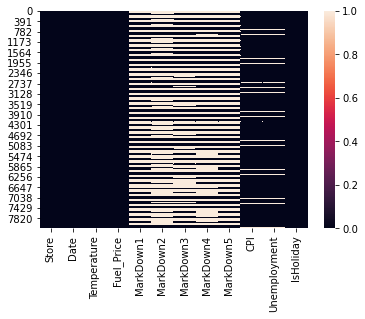

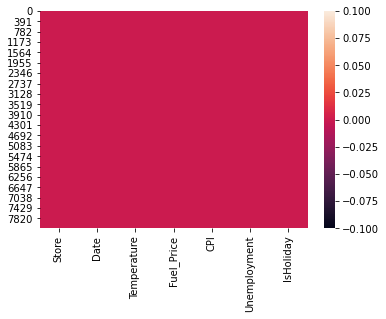

The total data has 421570 records 45 stores and 81 departments from Feb 05,2010 to Oct 26,2012
The train data has 323892 records 45 stores and 81 departments from Feb 05,2010 to Mar 09,2012
The test data has 97678 records 45 stores and 81 departments from Mar 16,2012 to Oct 26,2012
       Temperature   Fuel_Price          CPI  Unemployment
count  8190.000000  8190.000000  8190.000000   8190.000000
mean     59.356198     3.405992   172.460809      7.826821
std      18.678607     0.431337    38.292649      1.808963
min      -7.290000     2.472000   126.064000      3.684000
25%      45.902500     3.041000   132.653774      6.833000
50%      60.710000     3.513000   172.460809      7.826821
75%      73.880000     3.743000   212.766994      8.519000
max     101.950000     4.468000   228.976456     14.313000


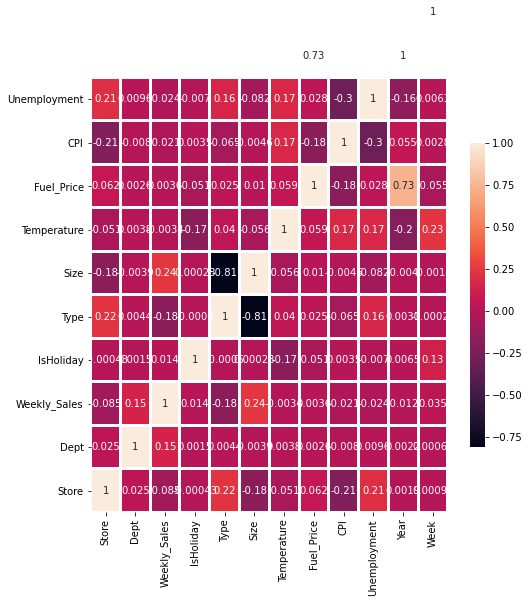

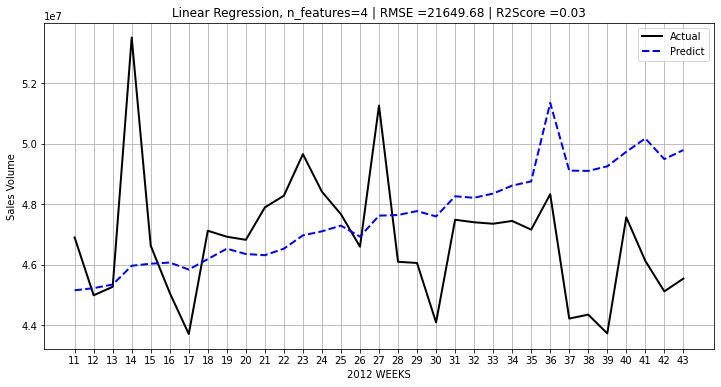

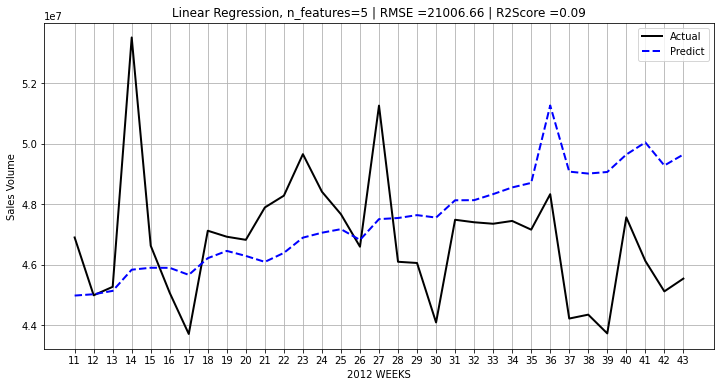

LGBM is starting with 4 features, please wait for less than 60 sec...
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[945]	valid_0's l1: 2913.57	valid_0's l2: 2.29831e+07
Starting training with custom eval function...
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[945]	valid_0's l2: 2.29831e+07	valid_0's RAE: 0.193924


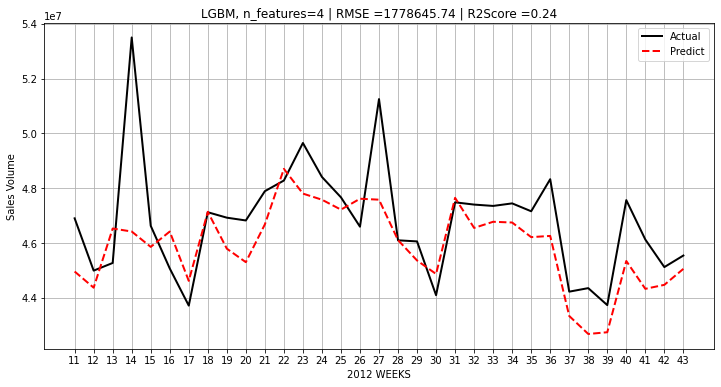

LGBM completes its 1000 rounds in 49sec
LGBM is starting with 5 features, please wait for less than 60 sec...
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2464.47	valid_0's l2: 1.93677e+07
Starting training with custom eval function...
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1.93677e+07	valid_0's RAE: 0.164032


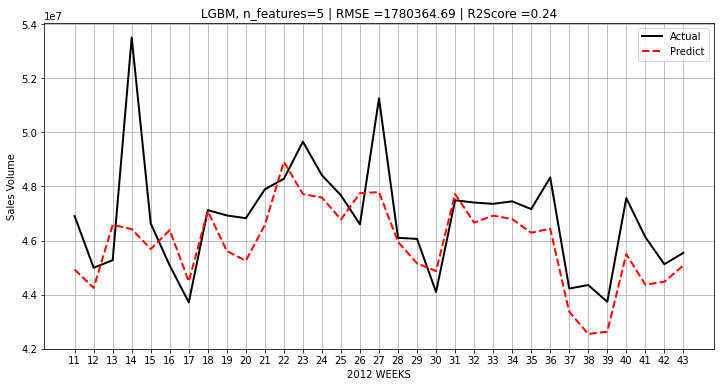

LGBM completes its 1000 rounds in 51sec
Random Forrest is starting with 4 features, please wait for less than 60 sec...


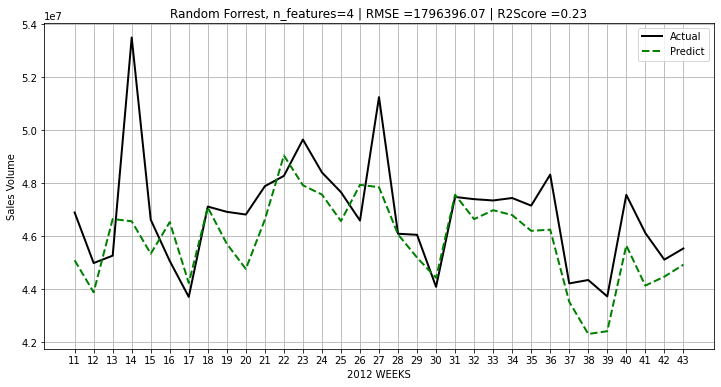

Random Forrest is starting with 5 features, please wait for less than 60 sec...


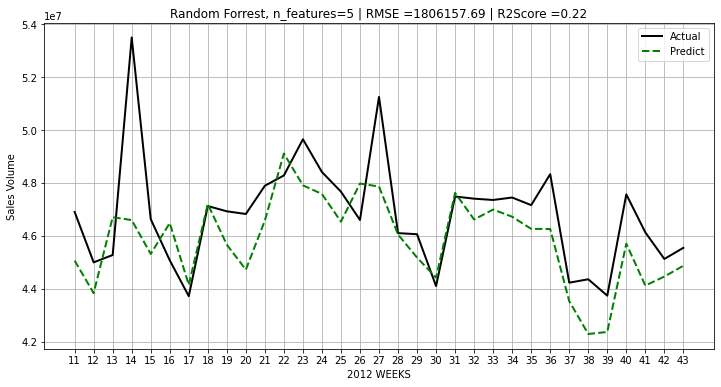

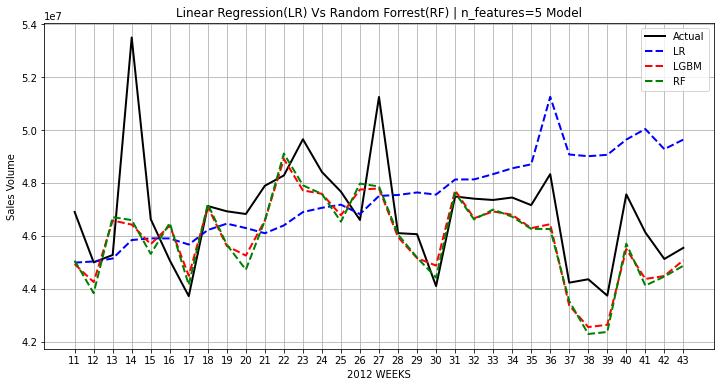

In [11]:
import os
import pandas as pd
import numpy as np
import warnings
import time
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor


pio.templates.default = "plotly_dark"
warnings.filterwarnings('ignore')

def initial_ETLs(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = (df['Date'].dt.strftime("%Y")).astype(int)
    df['Week'] = df['Date'].dt.week
    return df
def final_ETLs(df):
    # Converting IsHoliday from True/False to 1/0
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    # Converting StoreType A,B,C to 1,2,3
    df = df.replace({'Type' : { 'A': 1,'B' :2,'C':3 }})
    return df
def describle_data(df,dname):
    recs    = len(df)
    nstores = df['Store'].nunique()
    ndepart = df['Dept'].nunique()
    min_wks = df['Date'].min().strftime('%b %d,%Y')
    max_wks = df['Date'].max().strftime('%b %d,%Y')
    print(f"The {dname} data has {recs} records {nstores} stores and {ndepart} departments from {min_wks} to {max_wks}")
def get_act_vs_prd(dprd,ptitle='test',lcol='blue'):
    plt.figure(figsize=(12,6))
    xx  = dprd['Week'].astype(str)
    yy1 = dprd['Weekly_Sales_Actual']
    yy2 = dprd['Weekly_Sales_Predicted']
    plt.plot(xx, yy1, linewidth=2 ,color='black',label='Actual')
    plt.plot(xx, yy2, linewidth=2, color=lcol, linestyle="--", label='Predict')
    plt.xlabel('2012 WEEKS')
    plt.ylabel('Sales Volume')
    plt.grid()
    plt.title(ptitle)
    plt.legend()
    plt.show()
def rae(y_test, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_test)) / np.sum(np.abs(np.mean(y_test) - y_test)), False
def get_linear_regression(dtrain,dtest,ftrs):
    x_train = dtrain[ftrs].values.reshape(-1,len(ftrs))
    x_test  = dtest[ftrs].values.reshape(-1,len(ftrs))
    y_train = dtrain['Weekly_Sales']
    model   = LinearRegression().fit(x_train, y_train)
    dtest['Weekly_Sales_Predicted']   = model.predict(x_test)
    dtest = dtest.rename(columns={'Weekly_Sales':'Weekly_Sales_Actual'})
    dprd = dtest.groupby(['Year','Week'],as_index=False)[['Weekly_Sales_Actual','Weekly_Sales_Predicted']].sum()
    act, prd = dtest['Weekly_Sales_Actual'],dtest['Weekly_Sales_Predicted']
    rmse = str(round(np.sqrt(mean_squared_error(act,prd)),2))
    r2sc = str(round(r2_score(act,prd),2))
    ptitle = f'Linear Regression, n_features={len(ftrs)} | RMSE ={rmse} | R2Score ={r2sc}'
    get_act_vs_prd(dprd,ptitle)
    return dprd
def get_rf_regression(dtrain, dtest, ftrs):
    X_train = dtrain[ftrs]
    Y_train = dtrain['Weekly_Sales']
    mftr = len(ftrs)
    print(f"Random Forrest is starting with {mftr} features, please wait for less than 60 sec...")
    RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=mftr, min_samples_split=3, min_samples_leaf=1)
    RF.fit(X_train, Y_train)
    X_test  = dtest[ftrs]
    rf_prd = RF.predict(X_test)
    rf_test = dtest.copy()
    rf_test = rf_test.rename(columns={'Weekly_Sales':'Weekly_Sales_Actual'})
    rf_test['Weekly_Sales_Predicted'] = rf_prd
    drf = rf_test.groupby(['Year','Week'],as_index=False)[['Weekly_Sales_Actual','Weekly_Sales_Predicted']].sum()
    act, prd = drf['Weekly_Sales_Actual'],drf['Weekly_Sales_Predicted']
    rmse = str(round(np.sqrt(mean_squared_error(act,prd)),2))
    r2sc = str(round(r2_score(act,prd),2))
    ptitle = f'Random Forrest, n_features={mftr} | RMSE ={rmse} | R2Score ={r2sc}'
    get_act_vs_prd(drf,ptitle,lcol='green')
    return drf

def get_lgbm_regression(dtrain,dtest,ftrs2):
    start=time.time()
    lg_test = dtest[ftrs2+['Year','Weekly_Sales']]
    x_train, x_test=dtrain[ftrs2], dtest[ftrs2]
    y_train, y_test=dtrain['Weekly_Sales'], dtest['Weekly_Sales']
    leaves= 50 # Number of leaves in a tree (control complexity of tree)
    learn_rate = 0.05 # Step size towards minimum of a loss funtion
    estimators=1000 # Number of attempts to estimate the best fit
    early_rounds = 5  # Stop training if it doesn't improve for 5 rounds
    mftrs = len(ftrs2)
    print(f"LGBM is starting with {mftrs} features, please wait for less than 60 sec...")
    # First training with L1 evaluation metric (default)
    gbm = lgb.LGBMRegressor(num_leaves=leaves,learning_rate=learn_rate,n_estimators=estimators)
    gbm.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='l1',early_stopping_rounds=early_rounds,verbose=-1)
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

    print('Starting training with custom eval function...')
    # Second training with custom evaluaion metric, for example, RAE in this case
    gbm.fit(x_train, y_train,eval_set=[(x_test, y_test)],eval_metric=[rae],early_stopping_rounds=early_rounds,verbose=-1)
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
    lg_test['Weekly_Sales_Predicted']= y_pred

    lg_test = lg_test.rename(columns={'Weekly_Sales':'Weekly_Sales_Actual'})
    dlg = lg_test.groupby(['Year','Week'],as_index=False)[['Weekly_Sales_Actual','Weekly_Sales_Predicted']].sum()
    act, prd = dlg['Weekly_Sales_Actual'],dlg['Weekly_Sales_Predicted']
    rmse = str(round(np.sqrt(mean_squared_error(act,prd)),2))
    r2sc = str(round(r2_score(act,prd),2))
    ptitle = f'LGBM, n_features={mftrs} | RMSE ={rmse} | R2Score ={r2sc}'
    get_act_vs_prd(dlg,ptitle,lcol='red')
    end=time.time()
    time_sec = int(round((end-start),0))
    print(f"LGBM completes its {estimators} rounds in {time_sec}sec")
    return dlg

def compare_models(dlg2,drf2,dlr2):
    dmod1 = dlg2.copy()
    dmod2 = drf2.copy()
    mcol  = ['Year','Week']
    dmod1 = dmod1.rename(columns={'Weekly_Sales_Predicted':'LGBM'})
    dmod2 = dmod2.rename(columns={'Weekly_Sales_Predicted':'RF'})
    dmod  = dmod1.merge(dmod2[mcol+['RF']],on=mcol, how='left')
    dmod = dmod.merge(dlr2[mcol+['Weekly_Sales_Predicted']], on=mcol,how='left')
    dprd = dmod.rename(columns={'Weekly_Sales_Predicted':'LR', 'Weekly_Sales_Actual':'Actual'})
    plt.figure(figsize=(12,6))
    xx  = dprd['Week'].astype(str)
    y1, y2, y3, y4 = dprd['Actual'], dprd['LR'], dprd['RF'], dprd['LGBM']
    plt.plot(xx, y1, linewidth=2 ,color='black',label='Actual')
    plt.plot(xx, y2, linewidth=2, color='blue', linestyle="--", label='LR')
    plt.plot(xx, y4, linewidth=2, color='red', linestyle="--", label='LGBM')
    plt.plot(xx, y3, linewidth=2, color='green', linestyle="--", label='RF')
    
    plt.xlabel('2012 WEEKS')
    plt.ylabel('Sales Volume')
    plt.grid()
    plt.title('Linear Regression(LR) Vs Random Forrest(RF) | n_features=5 Model')
    plt.legend()
    plt.show()
path=os.getcwd()+'/Input/'
stores       = pd.read_csv(path+'stores.csv')
raw_features = pd.read_csv(path+'features.csv')
draw         = pd.read_csv(path+'walmart_data.csv')

merger_cols =['Store','Date','IsHoliday']
#Visually check nulls in raw_features
print(raw_features.isnull().mean()*100)
sns.heatmap(raw_features.isnull())
plt.show()
#Drop Coloumns having more than 60% nan, and filling others nan
markdown_cols = [col for col in raw_features.columns if 'MarkDown' in col]
features = raw_features.drop(markdown_cols,axis=1)
features['CPI']= features['CPI'].fillna(features['CPI'].mean())
features['Unemployment']= features['Unemployment'].fillna(features['Unemployment'].mean())
#Heat map after fixing nulls
sns.heatmap(features.isnull())
plt.show()
#What are store Types?
fig = px.bar(stores, x='Store', y='Size', color='Type', title=f"Walmart Store Types")
fig.show()
#Combine Stores and Features
dsf = stores.merge(features,on=['Store'],how='left') 
#Combine store and feature with the raw data
df1 = draw.merge(dsf,on=merger_cols,how='left')
# Get Necessary ETLs
df  = initial_ETLs(df1.copy())
#Describe overal data
describle_data(df.copy(),'total')
#Split data into train and test
split_point = (df['Year']==2012) & (df['Week']>10)
dtrain, dtest = df[~(split_point)], df[(split_point)]
#Describe train/test data
describle_data(dtrain.copy(),'train')
describle_data(dtest.copy(),'test')
#Describing train data statistics
print(features[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe())
#Departmentwise View of sale
dprtm = df.groupby(['Dept','Week'],as_index=False)['Weekly_Sales'].sum()
fig = px.line(dprtm, x='Week', y='Weekly_Sales', color='Dept', title=f"Department-wise Weekly Sales")
fig.show()
#Yearwise view of sale
dstr = df.groupby(['Week','Type'],as_index=False)['Weekly_Sales'].sum()
fig = px.line(dstr, x='Week', y='Weekly_Sales', color='Type', title=f"Weekly Sales")
fig.show()
#Visually check weekly sales trend for all years
dwkly = df.groupby(['Year','Week'],as_index=False)['Weekly_Sales'].sum()
fig = px.line(dwkly, x='Week', y='Weekly_Sales', color='Year', title=f"Year-wise Weekly Sales")
fig.show()
#Final ETL before using ML
dtrain = final_ETLs(dtrain.copy())
#Correlation Studies
fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(dtrain.corr(),linewidth=2,cbar_kws={"shrink":.7},annot=True)
ax.set_ylim(0, 10)
fig.show()
# Features to consider in Forecasting
ftrs1 = ['Week','Store','Dept','IsHoliday']
ftrs2 = ['Week','Store','Dept','IsHoliday','Size']
# Multivariate Linear Regressions
dlr1 = get_linear_regression(dtrain.copy(),dtest.copy(), ftrs1)
dlr2 = get_linear_regression(dtrain.copy(),dtest.copy(), ftrs2)
# LGBM Regressions
dlg1 = get_lgbm_regression(dtrain.copy(),dtest.copy(),ftrs1)
dlg2 = get_lgbm_regression(dtrain.copy(),dtest.copy(),ftrs2)
# Random Forrest Regressions
drf1 = get_rf_regression(dtrain.copy(), dtest.copy(), ftrs1)
drf2 = get_rf_regression(dtrain.copy(), dtest.copy(), ftrs2)
#Comparison of two Modeling Techniques
compare_models(dlg2.copy(),drf2.copy(),dlr2.copy())